In [2]:
from experiment_func_2 import *
import matplotlib.pyplot as plt
from LOST.object_discovery import lost
import cv2
import skimage 
%matplotlib inline

In [561]:
patch_size = 16
model = get_model('dino_base', patch_size=patch_size, device='cuda')

Pre-trained weights founde at dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth and loaded with msg : <All keys matched successfully>


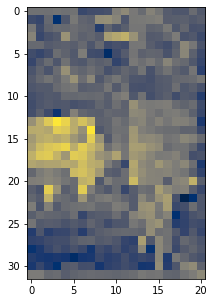

In [572]:
img_num =  '6_stars'
img_path = f'./examples/{img_num}.jpg'
scikit_img = load_image(img_path=img_path)
# scikit_img = skimage.transform.resize(scikit_img, (480,480))
plt.figure(figsize=(8,5))
img = img_ImageDataset(img_path=img_path)
input_image, w_featmap, h_featmap = img_prop(img=img, patch_size=patch_size)
cls_, output_, q_ , k_, v_ = get_feature(model=model, input_img=input_image )
cls_ = cls_[:-1]

sim_matrix = cls_feature_sim_matrix(cls=q_[-1][: , 0 , :], feats= k_[-1][:, 1:, :], dims=[w_featmap, h_featmap])
plt.imshow(sim_matrix, cmap = 'cividis')

In [566]:
input_image.shape

torch.Size([3, 512, 336])

In [573]:
scikit_img.shape

(500, 334, 3)

Query shape : torch.Size([1, 672, 768])
Key shape :torch.Size([1, 672, 768])
torch.Size([672, 672])
tensor(299, device='cuda:0')


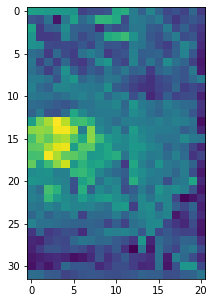

In [563]:
q = q_[-1][:, 1: , :]
k = k_[-1][:, 1: , :]
print(f"Query shape : {q.shape}")
print(f"Key shape :{k.shape}")
qk = (q@k.transpose(1,2)).squeeze(0)
qk_sum = torch.sum(qk, dim=-1)
qk_img = qk[torch.argmin(qk_sum), :].reshape(w_feamatp, h_featmap)
print(qk.shape)
print(torch.argmin(qk_sum))
plt.figure(figsize=(8,5))
plt.imshow(qk_img.cpu().numpy())

Query shape : torch.Size([1, 672, 768])
Key shape :torch.Size([1, 672, 768])
torch.Size([672, 672])
tensor(516, device='cuda:0')


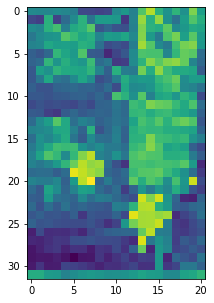

In [564]:
q = q_[-1][:, 1: , :]
k = k_[-1][:, 1: , :]
print(f"Query shape : {q.shape}")
print(f"Key shape :{k.shape}")
qk = (q@k.transpose(1,2)).squeeze(0)
qk_sum = torch.sum(qk, dim=-1)
qk_img = qk[torch.argmax(qk_sum), :].reshape(w_feamatp, h_featmap)
print(qk.shape)
print(torch.argmax(qk_sum))
plt.figure(figsize=(8,5))
plt.imshow(qk_img.cpu().numpy())

tensor(276, device='cuda:0')


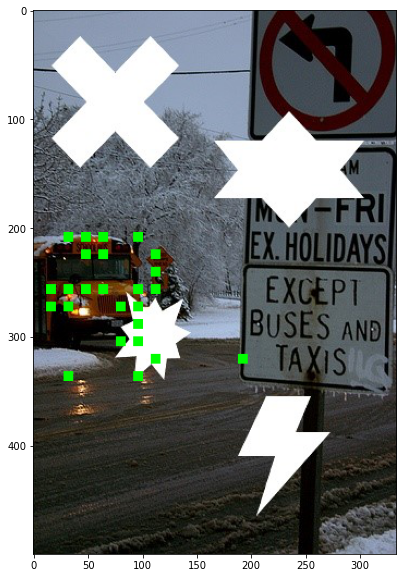

In [565]:
seed_image = scikit_img.copy()
# seed_image = skimage.transform.resize(seed_image, (480,480))
img = img_ImageDataset(img_path=img_path)
input_image, w_featmap, h_featmap = img_prop(img=img, patch_size=patch_size)
cls_, output_, q_ , k_, v_ = get_feature(model=model, input_img=input_image )
scales = [patch_size,patch_size]
cls_ = cls_[:-1]
cls = q_[-1][:, 0 , :]
k = k_[-1][:, 1: , :]
feat = k
sim = (cls@feat.transpose(1,2)).squeeze(0)
print(torch.argmax(sim))
value = torch.sort(sim, descending=True)[0][0]

pos_value = value[torch.where(value > 0 )[0]]
mean_pos_value = torch.mean(pos_value)
max_len = len(torch.where(value > 0 )[0])
where = torch.sort(sim, descending=True)[1][0, :max_len]

for tmp_seed in where:
    s_ = np.unravel_index(tmp_seed.cpu().numpy(), (w_featmap, h_featmap))
    size_ = np.asarray(scales) /2
    cv2.rectangle(
    seed_image,
        (int(s_[1] * scales[1] - (size_[1] / 2)), int(s_[0] * scales[0] - (size_[0] / 2))),
        (int(s_[1] * scales[1] + (size_[1] / 2)), int(s_[0] * scales[0] + (size_[0] / 2))),
        (0, 255 ,0), -1, 
    )
plt.figure(figsize=(16,10))
plt.imshow(seed_image)